# Housing Unaffordability: A Closer Look at Rent Trends and Homelessness

Code for data visualizations, and data cleaning



In [2]:
"""
Code block to import Google Drive
"""
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Just incase the environment doesn't have these libraries installed
Google Colab already has it

In [ ]:
!pip install pandas
!pip install geopandas
!pip install matplotlib
!pip install folium
!pip install plotly
!pip install seaborn
!pip install numpy

#### Libraries used for this project

In [3]:
#imported libraries for this project
from ast import Index
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import folium
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#### This function is meant to convert our excel file extensions to csv format for data processing. We utilized the pandas library to achieve this.

In [4]:
def convert_xlxs_to_csv(xlxs_filename, output_csv):
  """
  This function is meant to convert all the datasets obtained as XLXS into a CSV format for data manipulation.

  Parameters:
  xlxs_filename : Excel filename
  output_csv : Desired output include .csv extension
  """
  excel = pd.read_excel(xlxs_filename)
  excel.to_csv(output_csv, index=False)
  print("Successful")

## Reading All The Datasets
This contains all the datasets used in this code.

In [5]:
rent_income_census = pd.read_csv('/content/drive/MyDrive/CSE163 Project/Datasets/rent_income.csv', header=0)
zillow_rent = pd.read_csv('/content/drive/MyDrive/CSE163 Project/Datasets/zillow_rent_price.csv')
homeless2020 = pd.read_csv('/content/drive/MyDrive/CSE163 Project/Datasets/wa_pit_homeless2020.csv')
homeless2022 = pd.read_csv('/content/drive/MyDrive/CSE163 Project/Datasets/wa_pit_homeless2022.csv')
homeless_shelter2020 = pd.read_csv('/content/drive/MyDrive/CSE163 Project/Datasets/homeless_shelter_data2020.csv')
homeless_shelter2022 = pd.read_csv('/content/drive/MyDrive/CSE163 Project/Datasets/homeless_shelter_data2022.csv')
county_pop = pd.read_csv('/content/drive/MyDrive/CSE163 Project/Datasets/county_pop.csv')

In [6]:
rent_income_census

,Unnamed: 0,Total:,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,Label,NaN,Less than 10.0 percent,10.0 to 14.9 percent,15.0 to 19.9 percent,20.0 to 24.9 percent,25.0 to 29.9 percent,30.0 to 34.9 percent,35.0 to 39.9 percent,40.0 to 49.9 percent,50.0 percent or more,Not computed
1,"Adams County, Washington",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Estimate,"2,212",69,591,158,130,226,148,102,161,420,207
3,"Asotin County, Washington",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Estimate,"2,640",172,230,332,234,387,273,195,179,517,121
...,...,...,...,...,...,...,...,...,...,...,...,...
74,Estimate,"33,729",851,"1,890","3,940","3,971","3,493","2,595","2,808","3,335","9,355","1,491"
75,"Whitman County, Washington",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,Estimate,"9,840",292,839,865,795,612,386,586,832,"3,785",848
77,"Yakima County, Washington",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## rent_income.csv Data Cleaning
The dataset intially downloaded from the website had incorrect alignment with rows, and counties displaying NaN, and the estimates row below it displaying the values. So we cleaned it by removing the estimates row and giving that rows values to the county row for each county, and also removing/altering strings so we can merge the dataframe later with another dataset.

In [7]:
# Make first row as the header
new_header = rent_income_census.iloc[0]  # grab the first row for the header
rent_income_census = rent_income_census[1:]  # take the data less the header row
rent_income_census.columns = new_header  # set the header row as the df header

# Rename 'Total:' to 'Total'
rent_income_census = rent_income_census.rename(columns={'Total:': 'Total'})

In [8]:
#reassign column labels to "county" and "total"
rent_income_census.columns.values[0] = 'County'
rent_income_census.columns.values[1] = 'Total'

In [9]:
rent_income_census.columns = rent_income_census.columns.values
for index in range(len(rent_income_census) -1, -1, -1):  # Change this line to go to 0
    # Check if the current row is an 'Estimate' row
    if "Estimate" in rent_income_census.loc[index, 'County']:
        # Move 'Estimate' values up to the corresponding county row
        for col in rent_income_census.columns[1:]:
            # Only update if it's not the first row (avoid index out of bounds) and the value is not NaN
            if index > 0 and pd.notna(rent_income_census.loc[index, col]):
                rent_income_census.loc[index - 1, col] = rent_income_census.loc[index, col]
        # Remove the 'Estimate' row and reset the index
        rent_income_census.drop(index, inplace=True)
        rent_income_census.reset_index(drop=True, inplace=True)

# Drop duplicates, excluding the 'County' column
rent_income_census = rent_income_census.drop_duplicates(subset=rent_income_census.columns.difference(['County']))

# Remove ', Washington' from the 'County' column
rent_income_census['County'] = rent_income_census['County'].str.replace(', Washington', '')

In [10]:
string_numbers = []
numeric_cols = ['Total', 'Less than 10.0 percent', '10.0 to 14.9 percent',
                '15.0 to 19.9 percent', '20.0 to 24.9 percent', '25.0 to 29.9 percent',
                '30.0 to 34.9 percent', '35.0 to 39.9 percent', '40.0 to 49.9 percent',
                '50.0 percent or more', 'Not computed'
                ]
for col in numeric_cols:
    # Record the string representations of numbers
    string_numbers.extend(rent_income_census[col].loc[rent_income_census[col].apply(lambda x: isinstance(x, str))].tolist())
    # Remove commas and convert to numeric, replacing non-numeric values with NaNs
    rent_income_census[col] = pd.to_numeric(rent_income_census[col].str.replace(',', ''), errors='coerce')
print(rent_income_census.dtypes)

County                     object
Total                     float64
Less than 10.0 percent    float64
10.0 to 14.9 percent      float64
15.0 to 19.9 percent      float64
20.0 to 24.9 percent      float64
25.0 to 29.9 percent      float64
30.0 to 34.9 percent      float64
35.0 to 39.9 percent      float64
40.0 to 49.9 percent      float64
50.0 percent or more      float64
Not computed              float64
dtype: object


In [11]:
# reorganize the index after cleaning
rent_income_census = rent_income_census.reset_index(drop=True)

In [12]:
# to clean the very last row of the dataframe
yakima_index = rent_income_census.index[rent_income_census['County'] == 'Yakima County'].tolist()

if yakima_index and yakima_index[0] + 1 < len(rent_income_census):
    yakima_index = yakima_index[0]
    estimate_index = yakima_index + 1

    for col in rent_income_census.columns[1:]:
        rent_income_census.at[yakima_index, col] = rent_income_census.at[estimate_index, col]

    rent_income_census.drop(estimate_index, inplace=True)
    rent_income_census.reset_index(drop=True, inplace=True)

In [13]:
rent_income_census

,County,Total,Less than 10.0 percent,10.0 to 14.9 percent,15.0 to 19.9 percent,20.0 to 24.9 percent,25.0 to 29.9 percent,30.0 to 34.9 percent,35.0 to 39.9 percent,40.0 to 49.9 percent,50.0 percent or more,Not computed
0,Adams County,2212.0,69.0,591.0,158.0,130.0,226.0,148.0,102.0,161.0,420.0,207.0
1,Asotin County,2640.0,172.0,230.0,332.0,234.0,387.0,273.0,195.0,179.0,517.0,121.0
2,Benton County,24125.0,937.0,2530.0,2841.0,3165.0,2663.0,2156.0,1449.0,2502.0,4517.0,1365.0
3,Chelan County,11116.0,691.0,1151.0,1007.0,1634.0,1498.0,722.0,442.0,1014.0,1891.0,1066.0
4,Clallam County,9234.0,280.0,780.0,1328.0,897.0,847.0,670.0,482.0,1185.0,1866.0,899.0
5,Clark County,62839.0,1654.0,4864.0,7546.0,7752.0,8050.0,5697.0,4568.0,6091.0,13274.0,3343.0
6,Columbia County,450.0,54.0,21.0,108.0,11.0,55.0,37.0,11.0,15.0,70.0,68.0
7,Cowlitz County,14503.0,408.0,1067.0,1720.0,1781.0,1906.0,1396.0,1139.0,1293.0,3091.0,702.0
8,Douglas County,4654.0,342.0,384.0,699.0,553.0,452.0,292.0,278.0,95.0,854.0,705.0
9,Ferry County,721.0,77.0,54.0,87.0,41.0,33.0,44.0,47.0,66.0,101.0,171.0


In [14]:
# max values of all columns
rent_income_census.max()

County                    Yakima County
Total                          401313.0
Less than 10.0 percent          15460.0
10.0 to 14.9 percent            36924.0
15.0 to 19.9 percent            53568.0
20.0 to 24.9 percent            54386.0
25.0 to 29.9 percent            48377.0
30.0 to 34.9 percent            35643.0
35.0 to 39.9 percent            26496.0
40.0 to 49.9 percent            32446.0
50.0 percent or more            83511.0
Not computed                    14502.0
dtype: object

## Bar Plot Showing Income Spent on Rent
datasets used : rent_income.csv

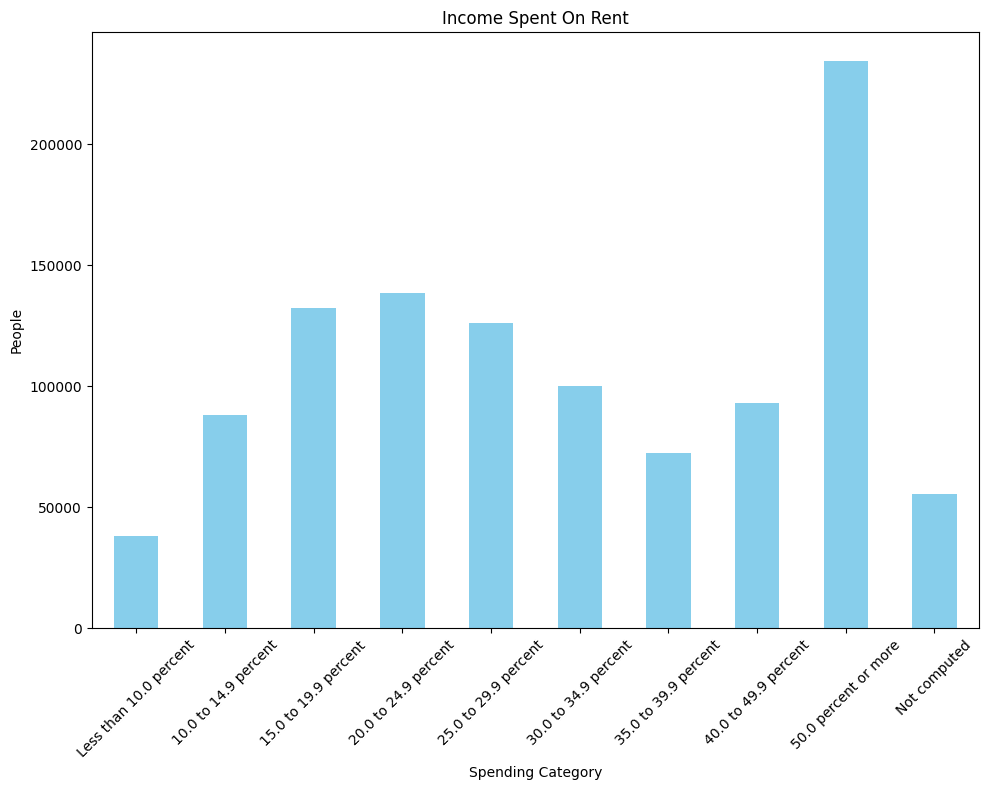

In [15]:
column_sums = rent_income_census.drop(['County', 'Total'], axis=1).sum()

plt.figure(figsize=(10, 8))
column_sums.plot(kind='bar', color='skyblue')
plt.title('Income Spent On Rent')
plt.xlabel('Spending Category')
plt.ylabel('People')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

# wa_pit_homeless2020 & 2022 Data Cleaning


In [16]:
homeless2020 = homeless2020.replace('< 11', 11).replace('*', 0)

In [17]:
homeless2020_column_names = [
    'County',
    'Persons of Household with no Minor',
    'Households with no Minors',
    'Persons in Households with Minors',
    'Households with Minors',
    'Persons in Households with only Minors',
    'Households with only Minors',
    'Total Persons',
    'Total Households'
]
homeless2020.columns = homeless2020_column_names
new_num_column_names = [
    'Persons of Household with no Minor',
    'Households with no Minors',
    'Persons in Households with Minors',
    'Households with Minors',
    'Persons in Households with only Minors',
    'Households with only Minors',
    'Total Persons',
    'Total Households'
]

num_col_values = []

for col in new_num_column_names:
    num_col_values.extend(homeless2020[col].loc[homeless2020[col].apply(lambda x: isinstance(x, str))].tolist())
    homeless2020[col] = pd.to_numeric(homeless2020[col]).astype(float)
homeless2020.dtypes

County                                     object
Persons of Household with no Minor        float64
Households with no Minors                 float64
Persons in Households with Minors         float64
Households with Minors                    float64
Persons in Households with only Minors    float64
Households with only Minors               float64
Total Persons                             float64
Total Households                          float64
dtype: object

In [18]:
homeless2020['Sum of people'] = homeless2020['Persons of Household with no Minor'] + homeless2020['Persons in Households with Minors'] + homeless2020['Persons in Households with only Minors']
homeless2020['Total Persons'] = homeless2020['Sum of people']
homeless2020['Sum of Households'] = homeless2020['Households with no Minors'] + homeless2020['Households with Minors'] + homeless2020['Households with only Minors']
homeless2020['Total Households'] = homeless2020['Sum of Households']
column_drop = ['Sum of people', 'Sum of Households']
homeless2020 = homeless2020.drop(columns = column_drop)
homeless2020

,County,Persons of Household with no Minor,Households with no Minors,Persons in Households with Minors,Households with Minors,Persons in Households with only Minors,Households with only Minors,Total Persons,Total Households
0,Adams County,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Asotin County,13.0,13.0,11.0,11.0,0.0,0.0,24.0,24.0
2,Benton County,50.0,50.0,81.0,23.0,11.0,11.0,142.0,84.0
3,Chelan County,229.0,215.0,92.0,30.0,16.0,11.0,337.0,256.0
4,Clallam County,151.0,147.0,46.0,16.0,11.0,11.0,208.0,174.0
5,Clark County,536.0,491.0,372.0,120.0,11.0,11.0,919.0,622.0
6,Columbia County,11.0,11.0,11.0,11.0,0.0,0.0,22.0,22.0
7,Cowlitz County,244.0,223.0,81.0,28.0,11.0,11.0,336.0,262.0
8,Douglas County,12.0,12.0,11.0,11.0,0.0,0.0,23.0,23.0
9,Ferry County,11.0,11.0,0.0,0.0,0.0,0.0,11.0,11.0


In [19]:
homeless2022 = homeless2022.replace('< 11', 11).replace('*', 0)

In [20]:
homeless2022_column_names = [
    'County',
    'Persons of Household with no Minor',
    'Households with no Minors',
    'Persons in Households with Minors',
    'Households with Minors',
    'Persons in Households with only Minors',
    'Households with only Minors',
    'Total Persons',
    'Total Households'
]
homeless2022.columns = homeless2022_column_names
new_num_column_names = [
    'Persons of Household with no Minor',
    'Households with no Minors',
    'Persons in Households with Minors',
    'Households with Minors',
    'Persons in Households with only Minors',
    'Households with only Minors',
    'Total Persons',
    'Total Households'
]

num_col_values = []

for col in new_num_column_names:
    num_col_values.extend(homeless2022[col].loc[homeless2022[col].apply(lambda x: isinstance(x, str))].tolist())
    homeless2022[col] = pd.to_numeric(homeless2022[col]).astype(float)
homeless2022.dtypes

County                                     object
Persons of Household with no Minor        float64
Households with no Minors                 float64
Persons in Households with Minors         float64
Households with Minors                    float64
Persons in Households with only Minors    float64
Households with only Minors               float64
Total Persons                             float64
Total Households                          float64
dtype: object

In [21]:
homeless_2022 = homeless2022.drop(index=39)

In [22]:
homeless2022['Sum of people'] = homeless2022['Persons of Household with no Minor'] + homeless2022['Persons in Households with Minors'] + homeless2022['Persons in Households with only Minors']
homeless2022['Total Persons'] = homeless2022['Sum of people']
homeless2022['Sum of Households'] = homeless2022['Households with no Minors'] + homeless2022['Households with Minors'] + homeless2022['Households with only Minors']
homeless2022['Total Households'] = homeless2022['Sum of Households']
column_drop = ['Sum of people', 'Sum of Households']
homeless2022 = homeless2022.drop(columns = column_drop)
homeless2022

,County,Persons of Household with no Minor,Households with no Minors,Persons in Households with Minors,Households with Minors,Persons in Households with only Minors,Households with only Minors,Total Persons,Total Households
0,Adams County,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Asotin County,71.0,63.0,24.0,11.0,0.0,0.0,95.0,74.0
2,Benton County,78.0,69.0,111.0,32.0,13.0,13.0,202.0,114.0
3,Chelan County,246.0,226.0,143.0,41.0,0.0,0.0,389.0,267.0
4,Clallam County,118.0,116.0,60.0,20.0,0.0,0.0,178.0,136.0
5,Clark County,785.0,695.0,632.0,198.0,21.0,21.0,1438.0,914.0
6,Columbia County,17.0,17.0,0.0,0.0,0.0,0.0,17.0,17.0
7,Cowlitz County,174.0,167.0,97.0,30.0,0.0,0.0,271.0,197.0
8,Douglas County,11.0,11.0,11.0,11.0,0.0,0.0,22.0,22.0
9,Ferry County,11.0,11.0,11.0,11.0,0.0,0.0,22.0,22.0


# Zillow Rent Data (By Time)
This is the visualization of zillow_rent_price.csv.
We melted to the dataframe to represent a single observation of rent per specfic region and a specific date. This melting process converts the dataset from one column per time period to having one row per time period, with rent values aligned alongside the correct dates and region.

In [23]:
zillow_rent.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,State,Metro,StateCodeFIPS,MunicipalCodeFIPS,1/31/2015,...,4/30/2023,5/31/2023,6/30/2023,7/31/2023,8/31/2023,9/30/2023,10/31/2023,11/30/2023,12/31/2023,1/31/2024
0,3101,0,Los Angeles County,county,CA,CA,"Los Angeles-Long Beach-Anaheim, CA",6,37,1776.567465,...,2771.995961,2777.228511,2785.536906,2792.929868,2801.705622,2803.596024,2800.984907,2790.870323,2783.335135,2785.102892
1,139,1,Cook County,county,IL,IL,"Chicago-Naperville-Elgin, IL-IN-WI",17,31,1445.120815,...,1925.106443,1950.088286,1970.440023,1982.117579,1987.074699,1981.658545,1969.576929,1958.412818,1960.957242,1973.616367
2,1090,2,Harris County,county,TX,TX,"Houston-The Woodlands-Sugar Land, TX",48,201,1206.425013,...,1589.906146,1599.097788,1608.366280,1615.989129,1617.336094,1615.528413,1610.872183,1606.715132,1606.000454,1608.716707
3,2402,3,Maricopa County,county,AZ,AZ,"Phoenix-Mesa-Chandler, AZ",4,13,955.578570,...,1848.342327,1856.980671,1857.442299,1861.053096,1860.631889,1858.492465,1853.904365,1844.183060,1836.573508,1833.607640
4,2841,4,San Diego County,county,CA,CA,"San Diego-Chula Vista-Carlsbad, CA",6,73,1700.015970,...,2943.663855,2982.325174,3008.274888,3027.181872,3035.209208,3033.045781,3019.007427,2995.634403,2975.039500,2963.970587


In [24]:
wa_zillow = zillow_rent[zillow_rent['State'] == 'WA']
time_measure = wa_zillow.columns[9:]
wa_zillow_melted = pd.melt(wa_zillow, id_vars=['RegionName'],
                           value_vars= time_measure, var_name='Date', value_name='Rent')
wa_zillow_melted['Date'] = pd.to_datetime(wa_zillow_melted['Date'], format='%m/%d/%Y')

In [25]:
wa_zillow_melted['Year'] = wa_zillow_melted['Date'].dt.year
yearly_avg_rent = wa_zillow_melted.groupby(['RegionName', 'Year'])['Rent'].mean().reset_index()
yearly_avg_rent['Pct_Change'] = yearly_avg_rent.groupby('RegionName')['Rent'].pct_change() * 100
yearly_avg_rent = yearly_avg_rent.dropna()
max_increase_per_county = yearly_avg_rent.groupby('RegionName')['Pct_Change'].max().reset_index()
max_increase_per_county_sorted = max_increase_per_county.sort_values(by='Pct_Change', ascending=False)

In [26]:
wa_zillow_melted

,RegionName,Date,Rent,Year
0,King County,2015-01-31,1487.104228,2015
1,Pierce County,2015-01-31,1027.814040,2015
2,Snohomish County,2015-01-31,1239.144701,2015
3,Spokane County,2015-01-31,749.701925,2015
4,Clark County,2015-01-31,1073.868408,2015
...,...,...,...,...
2720,Walla Walla County,2024-01-31,1561.388889,2024
2721,Whitman County,2024-01-31,1417.639205,2024
2722,Kittitas County,2024-01-31,1452.555556,2024
2723,Douglas County,2024-01-31,1842.500000,2024


# Chart displaying rent trends across Washington counties
dataset used: zillow_rent_price.csv

In [27]:
rent_trend = px.line(wa_zillow_melted, x='Date', y='Rent', color='RegionName', title='Monthly Rent Trends by County in Washington State')

rent_trend.update_layout(
    xaxis_title='Date/Year',
    yaxis_title='Average Rent($)',
    legend_title='County',
    width=1000, # Set the width as desired
    height=600 ,  # Set the height as desired
    # positioning of legend below the plot
    legend=dict(
        orientation="h",  # Horizontal orientation
        yanchor="bottom",
        y=-0.50,
        xanchor="center",
        x=0.5
    ),
)

rent_trend.show()

# Bar plot showing percent change in rent
dataset used: zillow_rent_price.csv

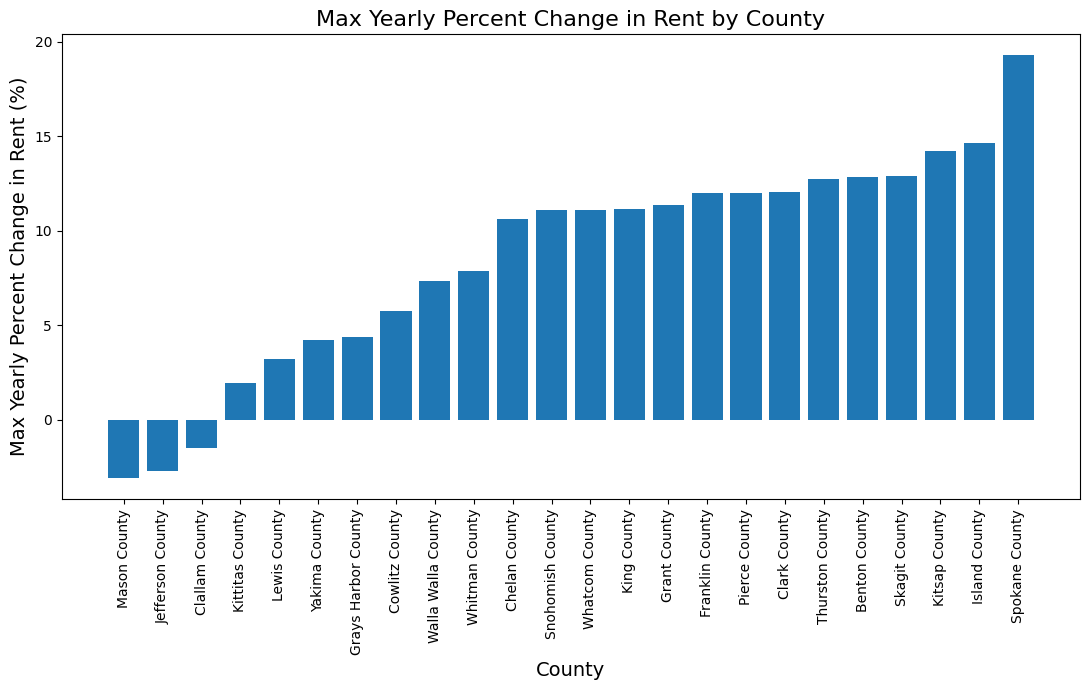

In [28]:
wa_zillow_melted['Year'] = wa_zillow_melted['Date'].dt.year

yearly_avg_rent = wa_zillow_melted.groupby(['RegionName', 'Year'])['Rent'].mean().reset_index()
yearly_avg_rent['Pct_Change'] = yearly_avg_rent.groupby('RegionName')['Rent'].pct_change() * 100

yearly_avg_rent = yearly_avg_rent.dropna()

max_increase_per_county = yearly_avg_rent.groupby('RegionName')['Pct_Change'].max().reset_index()
max_increase_per_county_sorted = max_increase_per_county.sort_values(by='Pct_Change')

plt.figure(figsize=(11, 7))
plt.bar(max_increase_per_county_sorted['RegionName'], max_increase_per_county_sorted['Pct_Change'])
plt.xticks(rotation=90)

plt.xlabel('County', fontsize=14)
plt.ylabel('Max Yearly Percent Change in Rent (%)', fontsize=14)
plt.title('Max Yearly Percent Change in Rent by County', fontsize=16)
plt.tight_layout()

plt.show()

# Merging rent_income_census & GeoDataFrame
This section performs merging operations from a shapefile and merging by "County" to provide geometry so we can map out our data. We got the WA shapefile from U.S. Census which provides geometry coordinates and county names, we then merged with county names to achieve geometry.

In [29]:
counties_layer = gpd.read_file('/content/drive/MyDrive/CSE163 Project/Datasets/WA_County_Boundaries')

In [30]:
counties_layer.head()

,OBJECTID,JURISDICT_,JURISDIC_1,JURISDIC_2,JURISDIC_3,JURISDIC_4,JURISDIC_5,JURISDIC_6,EDIT_DATE,EDIT_STATU,EDIT_WHO,GLOBALID,geometry
0,52002,25,4,Grant,Grant County,13,53025,None,2018-03-15,1,TSTE490,{294E70C7-27E7-4699-BA2C-93E5AD37A747},"POLYGON ((-13245041.204 6100462.041, -13245049..."
1,56163,33,4,Garfield,Garfield County,12,53023,None,2022-06-23,1,TSTE490,{9B3E2F19-8942-4680-B112-3DFEC7DCB14C},"POLYGON ((-13077215.155 5893282.479, -13076922..."
2,56525,8,4,Island,Island County,15,53029,None,2018-03-15,1,TSTE490,{D9DD1789-7BAC-41F9-B5A3-29E2287189D6},"POLYGON ((-13645903.473 6175425.382, -13645833..."
3,57153,4699350,4,Kittitas,Kittitas County,19,53037,None,2023-07-27,0,TSTE490,{601FAD56-613F-488B-B85E-28F3BD212CFD},"POLYGON ((-13482428.890 6040101.397, -13482417..."
4,57197,35,4,Walla Walla,Walla Walla County,36,53071,None,2015-10-14,1,JDUG490,{E6C7AF2E-BBDB-41DD-90A0-C4E49634461D},"POLYGON ((-13170470.944 5878093.595, -13170220..."


In [31]:
county_col_drop = ['EDIT_DATE', 'JURISDIC_2','GLOBALID', 'EDIT_STATU', 'EDIT_WHO', 'JURISDIC_1', 'JURISDIC_6','OBJECTID','JURISDICT_','JURISDIC_4']
counties_layer = counties_layer.drop(columns=county_col_drop)

In [32]:
counties_layer.columns.values[0] = 'County'
counties_layer.columns.values[1] = 'FIPS'

In [33]:
counties_layer.head()

,County,FIPS,geometry
0,Grant County,53025,"POLYGON ((-13245041.204 6100462.041, -13245049..."
1,Garfield County,53023,"POLYGON ((-13077215.155 5893282.479, -13076922..."
2,Island County,53029,"POLYGON ((-13645903.473 6175425.382, -13645833..."
3,Kittitas County,53037,"POLYGON ((-13482428.890 6040101.397, -13482417..."
4,Walla Walla County,53071,"POLYGON ((-13170470.944 5878093.595, -13170220..."


In [34]:
print(counties_layer.columns)
print(rent_income_census.columns)
counties_layer.columns = counties_layer.columns.str.strip()
rent_income_census.columns = rent_income_census.columns.str.strip()

Index(['County', 'FIPS', 'geometry'], dtype='object')
Index(['County', 'Total', 'Less than 10.0 percent', '10.0 to 14.9 percent',
       '15.0 to 19.9 percent', '20.0 to 24.9 percent', '25.0 to 29.9 percent',
       '30.0 to 34.9 percent', '35.0 to 39.9 percent', '40.0 to 49.9 percent',
       '50.0 percent or more', 'Not computed'],
      dtype='object')


In [35]:
merged_rent_data = counties_layer.merge(rent_income_census, on='County', how='left')

In [36]:
merged_rent_data

,County,FIPS,geometry,Total,Less than 10.0 percent,10.0 to 14.9 percent,15.0 to 19.9 percent,20.0 to 24.9 percent,25.0 to 29.9 percent,30.0 to 34.9 percent,35.0 to 39.9 percent,40.0 to 49.9 percent,50.0 percent or more,Not computed
0,Grant County,53025,"POLYGON ((-13245041.204 6100462.041, -13245049...",11861.0,931.0,1199.0,1750.0,1324.0,1098.0,1079.0,662.0,639.0,1855.0,1324.0
1,Garfield County,53023,"POLYGON ((-13077215.155 5893282.479, -13076922...",227.0,9.0,41.0,10.0,16.0,10.0,30.0,0.0,10.0,39.0,62.0
2,Island County,53029,"POLYGON ((-13645903.473 6175425.382, -13645833...",9291.0,238.0,842.0,814.0,1350.0,918.0,1135.0,647.0,825.0,1885.0,637.0
3,Kittitas County,53037,"POLYGON ((-13482428.890 6040101.397, -13482417...",7402.0,272.0,420.0,1051.0,823.0,592.0,430.0,428.0,475.0,2284.0,627.0
4,Walla Walla County,53071,"POLYGON ((-13170470.944 5878093.595, -13170220...",7778.0,248.0,440.0,661.0,1007.0,922.0,533.0,715.0,810.0,1744.0,698.0
5,Columbia County,53013,"POLYGON ((-13119277.932 5875313.561, -13119349...",450.0,54.0,21.0,108.0,11.0,55.0,37.0,11.0,15.0,70.0,68.0
6,San Juan County,53055,"POLYGON ((-13678738.782 6239384.542, -13678710...",1945.0,75.0,174.0,192.0,213.0,158.0,140.0,102.0,127.0,422.0,342.0
7,Asotin County,53003,"POLYGON ((-13046628.720 5847940.517, -13046278...",2640.0,172.0,230.0,332.0,234.0,387.0,273.0,195.0,179.0,517.0,121.0
8,Franklin County,53021,"POLYGON ((-13159766.598 5899385.299, -13159880...",8526.0,521.0,902.0,903.0,951.0,862.0,835.0,584.0,730.0,1533.0,705.0
9,Pend Oreille County,53051,"POLYGON ((-13080281.031 6138101.060, -13080277...",1374.0,168.0,57.0,134.0,102.0,68.0,101.0,89.0,124.0,198.0,333.0


In [37]:
pop_col_drop = ['county', 'city']
county_pop = county_pop.drop(columns=pop_col_drop)

In [39]:
merged_rent_data = merged_rent_data.merge(county_pop, left_on='County', right_on='name', how='left')

In [40]:
merged_rent_data['% of 50 percent'] = (merged_rent_data['50.0 percent or more'] / merged_rent_data['Total']) * 100
merged_rent_data['% of 30 percent'] = (merged_rent_data['30.0 to 34.9 percent'] / merged_rent_data['Total']) * 100
merged_rent_data['% of 40 percent'] = (merged_rent_data['40.0 to 49.9 percent'] / merged_rent_data['Total']) * 100

In [41]:
merged_rent_data

,County,FIPS,geometry,Total,Less than 10.0 percent,10.0 to 14.9 percent,15.0 to 19.9 percent,20.0 to 24.9 percent,25.0 to 29.9 percent,30.0 to 34.9 percent,35.0 to 39.9 percent,40.0 to 49.9 percent,50.0 percent or more,Not computed,name,state,population,% of 50 percent,% of 30 percent,% of 40 percent
0,Grant County,53025,"POLYGON ((-13245041.204 6100462.041, -13245049...",11861.0,931.0,1199.0,1750.0,1324.0,1098.0,1079.0,662.0,639.0,1855.0,1324.0,Grant County,Washington,99145,15.639491,9.097041,5.387404
1,Garfield County,53023,"POLYGON ((-13077215.155 5893282.479, -13076922...",227.0,9.0,41.0,10.0,16.0,10.0,30.0,0.0,10.0,39.0,62.0,Garfield County,Washington,2310,17.180617,13.215859,4.405286
2,Island County,53029,"POLYGON ((-13645903.473 6175425.382, -13645833...",9291.0,238.0,842.0,814.0,1350.0,918.0,1135.0,647.0,825.0,1885.0,637.0,Island County,Washington,86510,20.288451,12.216123,8.879561
3,Kittitas County,53037,"POLYGON ((-13482428.890 6040101.397, -13482417...",7402.0,272.0,420.0,1051.0,823.0,592.0,430.0,428.0,475.0,2284.0,627.0,Kittitas County,Washington,44424,30.856525,5.809241,6.417185
4,Walla Walla County,53071,"POLYGON ((-13170470.944 5878093.595, -13170220...",7778.0,248.0,440.0,661.0,1007.0,922.0,533.0,715.0,810.0,1744.0,698.0,Walla Walla County,Washington,62150,22.422217,6.852661,10.413988
5,Columbia County,53013,"POLYGON ((-13119277.932 5875313.561, -13119349...",450.0,54.0,21.0,108.0,11.0,55.0,37.0,11.0,15.0,70.0,68.0,Columbia County,Washington,3980,15.555556,8.222222,3.333333
6,San Juan County,53055,"POLYGON ((-13678738.782 6239384.542, -13678710...",1945.0,75.0,174.0,192.0,213.0,158.0,140.0,102.0,127.0,422.0,342.0,San Juan County,Washington,18001,21.696658,7.197943,6.529563
7,Asotin County,53003,"POLYGON ((-13046628.720 5847940.517, -13046278...",2640.0,172.0,230.0,332.0,234.0,387.0,273.0,195.0,179.0,517.0,121.0,Asotin County,Washington,22370,19.583333,10.340909,6.780303
8,Franklin County,53021,"POLYGON ((-13159766.598 5899385.299, -13159880...",8526.0,521.0,902.0,903.0,951.0,862.0,835.0,584.0,730.0,1533.0,705.0,Franklin County,Washington,96692,17.980296,9.793573,8.562046
9,Pend Oreille County,53051,"POLYGON ((-13080281.031 6138101.060, -13080277...",1374.0,168.0,57.0,134.0,102.0,68.0,101.0,89.0,124.0,198.0,333.0,Pend Oreille County,Washington,13570,14.410480,7.350801,9.024745


### Map displaying population density of households experience high burden of rent cost (Households who spend more than 50 percent of their income on rent

dataset used: rent_income.csv & population dataset

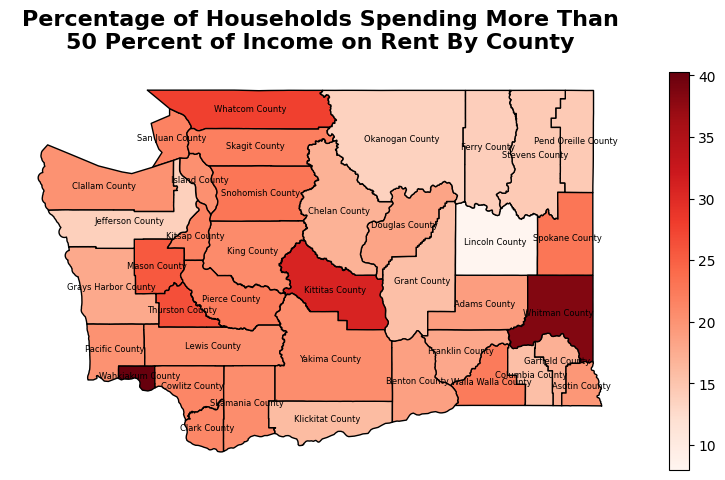

In [42]:
fig, ax = plt.subplots(figsize=(10, 8))

merged_rent_data.plot(ax=ax, column='% of 50 percent', cmap='Reds', edgecolor='black', legend=True)

title_text = "Percentage of Households Spending More Than\n50 Percent of Income on Rent By County"
ax.set_title(title_text, fontsize=16, fontweight='bold', loc='center')

for idx, row in merged_rent_data.iterrows():
    centroid = row.geometry.centroid
    ax.text(centroid.x, centroid.y, row['County'], fontsize=6, ha='center', va='center')

cbar = fig.axes[-1]
ax_pos = ax.get_position()
cbar.set_position([cbar.get_position().x0, ax_pos.y0, cbar.get_position().width, ax_pos.height])
ax.set_axis_off()

plt.show()

#### Merging homelessness 2020 data with shapefile to map out those rates.

In [43]:
merged_homeless2020_data = counties_layer.merge(homeless2020, on='County', how='left')

In [44]:
merged_homeless2020_data

,County,FIPS,geometry,Persons of Household with no Minor,Households with no Minors,Persons in Households with Minors,Households with Minors,Persons in Households with only Minors,Households with only Minors,Total Persons,Total Households
0,Grant County,53025,"POLYGON ((-13245041.204 6100462.041, -13245049...",104.0,97.0,75.0,19.0,11.0,11.0,190.0,127.0
1,Garfield County,53023,"POLYGON ((-13077215.155 5893282.479, -13076922...",11.0,11.0,11.0,11.0,0.0,0.0,22.0,22.0
2,Island County,53029,"POLYGON ((-13645903.473 6175425.382, -13645833...",105.0,94.0,24.0,11.0,0.0,0.0,129.0,105.0
3,Kittitas County,53037,"POLYGON ((-13482428.890 6040101.397, -13482417...",11.0,11.0,11.0,11.0,11.0,11.0,33.0,33.0
4,Walla Walla County,53071,"POLYGON ((-13170470.944 5878093.595, -13170220...",123.0,122.0,11.0,11.0,11.0,11.0,145.0,144.0
5,Columbia County,53013,"POLYGON ((-13119277.932 5875313.561, -13119349...",11.0,11.0,11.0,11.0,0.0,0.0,22.0,22.0
6,San Juan County,53055,"POLYGON ((-13678738.782 6239384.542, -13678710...",55.0,55.0,11.0,11.0,0.0,0.0,66.0,66.0
7,Asotin County,53003,"POLYGON ((-13046628.720 5847940.517, -13046278...",13.0,13.0,11.0,11.0,0.0,0.0,24.0,24.0
8,Franklin County,53021,"POLYGON ((-13159766.598 5899385.299, -13159880...",44.0,44.0,11.0,11.0,11.0,11.0,66.0,66.0
9,Pend Oreille County,53051,"POLYGON ((-13080281.031 6138101.060, -13080277...",11.0,11.0,29.0,11.0,11.0,11.0,51.0,33.0


In [45]:
merged_homeless2020_data['Proportion of Persons Homeless'] = (merged_homeless2020_data['Total Persons'] / merged_rent_data['Total'])

In [46]:
# check current crs, as we may need to change it to convert the geometries to area per square mile
current_crs = merged_homeless2020_data.crs
print(current_crs)

EPSG:3857


In [47]:
merged_homeless2020_data

,County,FIPS,geometry,Persons of Household with no Minor,Households with no Minors,Persons in Households with Minors,Households with Minors,Persons in Households with only Minors,Households with only Minors,Total Persons,Total Households,Proportion of Persons Homeless
0,Grant County,53025,"POLYGON ((-13245041.204 6100462.041, -13245049...",104.0,97.0,75.0,19.0,11.0,11.0,190.0,127.0,0.016019
1,Garfield County,53023,"POLYGON ((-13077215.155 5893282.479, -13076922...",11.0,11.0,11.0,11.0,0.0,0.0,22.0,22.0,0.096916
2,Island County,53029,"POLYGON ((-13645903.473 6175425.382, -13645833...",105.0,94.0,24.0,11.0,0.0,0.0,129.0,105.0,0.013884
3,Kittitas County,53037,"POLYGON ((-13482428.890 6040101.397, -13482417...",11.0,11.0,11.0,11.0,11.0,11.0,33.0,33.0,0.004458
4,Walla Walla County,53071,"POLYGON ((-13170470.944 5878093.595, -13170220...",123.0,122.0,11.0,11.0,11.0,11.0,145.0,144.0,0.018642
5,Columbia County,53013,"POLYGON ((-13119277.932 5875313.561, -13119349...",11.0,11.0,11.0,11.0,0.0,0.0,22.0,22.0,0.048889
6,San Juan County,53055,"POLYGON ((-13678738.782 6239384.542, -13678710...",55.0,55.0,11.0,11.0,0.0,0.0,66.0,66.0,0.033933
7,Asotin County,53003,"POLYGON ((-13046628.720 5847940.517, -13046278...",13.0,13.0,11.0,11.0,0.0,0.0,24.0,24.0,0.009091
8,Franklin County,53021,"POLYGON ((-13159766.598 5899385.299, -13159880...",44.0,44.0,11.0,11.0,11.0,11.0,66.0,66.0,0.007741
9,Pend Oreille County,53051,"POLYGON ((-13080281.031 6138101.060, -13080277...",11.0,11.0,29.0,11.0,11.0,11.0,51.0,33.0,0.037118


In [48]:
merged_homeless2020_data = merged_homeless2020_data.to_crs(epsg=5070)
# the value was found online "2.58998811e+6", this gives us the square mile of each county.
merged_homeless2020_data['Area Square Mile'] = merged_homeless2020_data['geometry'].area / 2.58998811e+6

# create a new column calculating homeless density per county
merged_homeless2020_data['Homeless Density'] = merged_homeless2020_data['Total Persons'] / merged_homeless2020_data['Area Square Mile']

In [49]:
# change back to correct projection
merged_homeless2020_data = merged_homeless2020_data.to_crs(epsg=3857)

In [50]:
# assert statements to check if area square mile was correctly calculated,
# information on square mile obtained from Google search

correct_sq_mi_king_county = 2307
correct_grant_county = 2791

sq_mi_king_county = int(merged_homeless2020_data.loc[merged_homeless2020_data['County'] == 'King County', 'Area Square Mile'].iloc[0])
sq_mi_grant_county = int(merged_homeless2020_data.loc[merged_homeless2020_data['County'] == 'Grant County', 'Area Square Mile'].iloc[0])

assert sq_mi_king_county == correct_sq_mi_king_county, "No Match"
assert sq_mi_grant_county == correct_grant_county, "No Match"

In [51]:
merged_homeless2020_data

,County,FIPS,geometry,Persons of Household with no Minor,Households with no Minors,Persons in Households with Minors,Households with Minors,Persons in Households with only Minors,Households with only Minors,Total Persons,Total Households,Proportion of Persons Homeless,Area Square Mile,Homeless Density
0,Grant County,53025,"POLYGON ((-13245041.204 6100462.041, -13245049...",104.0,97.0,75.0,19.0,11.0,11.0,190.0,127.0,0.016019,2791.509308,0.068064
1,Garfield County,53023,"POLYGON ((-13077215.155 5893282.479, -13076922...",11.0,11.0,11.0,11.0,0.0,0.0,22.0,22.0,0.096916,718.303625,0.030628
2,Island County,53029,"POLYGON ((-13645903.473 6175425.382, -13645833...",105.0,94.0,24.0,11.0,0.0,0.0,129.0,105.0,0.013884,519.285584,0.248418
3,Kittitas County,53037,"POLYGON ((-13482428.890 6040101.397, -13482417...",11.0,11.0,11.0,11.0,11.0,11.0,33.0,33.0,0.004458,2332.997125,0.014145
4,Walla Walla County,53071,"POLYGON ((-13170470.944 5878093.595, -13170220...",123.0,122.0,11.0,11.0,11.0,11.0,145.0,144.0,0.018642,1298.849463,0.111637
5,Columbia County,53013,"POLYGON ((-13119277.932 5875313.561, -13119349...",11.0,11.0,11.0,11.0,0.0,0.0,22.0,22.0,0.048889,873.656769,0.025182
6,San Juan County,53055,"POLYGON ((-13678738.782 6239384.542, -13678710...",55.0,55.0,11.0,11.0,0.0,0.0,66.0,66.0,0.033933,621.780599,0.106147
7,Asotin County,53003,"POLYGON ((-13046628.720 5847940.517, -13046278...",13.0,13.0,11.0,11.0,0.0,0.0,24.0,24.0,0.009091,640.378302,0.037478
8,Franklin County,53021,"POLYGON ((-13159766.598 5899385.299, -13159880...",44.0,44.0,11.0,11.0,11.0,11.0,66.0,66.0,0.007741,1265.038501,0.052172
9,Pend Oreille County,53051,"POLYGON ((-13080281.031 6138101.060, -13080277...",11.0,11.0,29.0,11.0,11.0,11.0,51.0,33.0,0.037118,1425.674397,0.035773


# Four subplot maps displaying proportion measures, density, and counts
dataset used: rent_income.csv

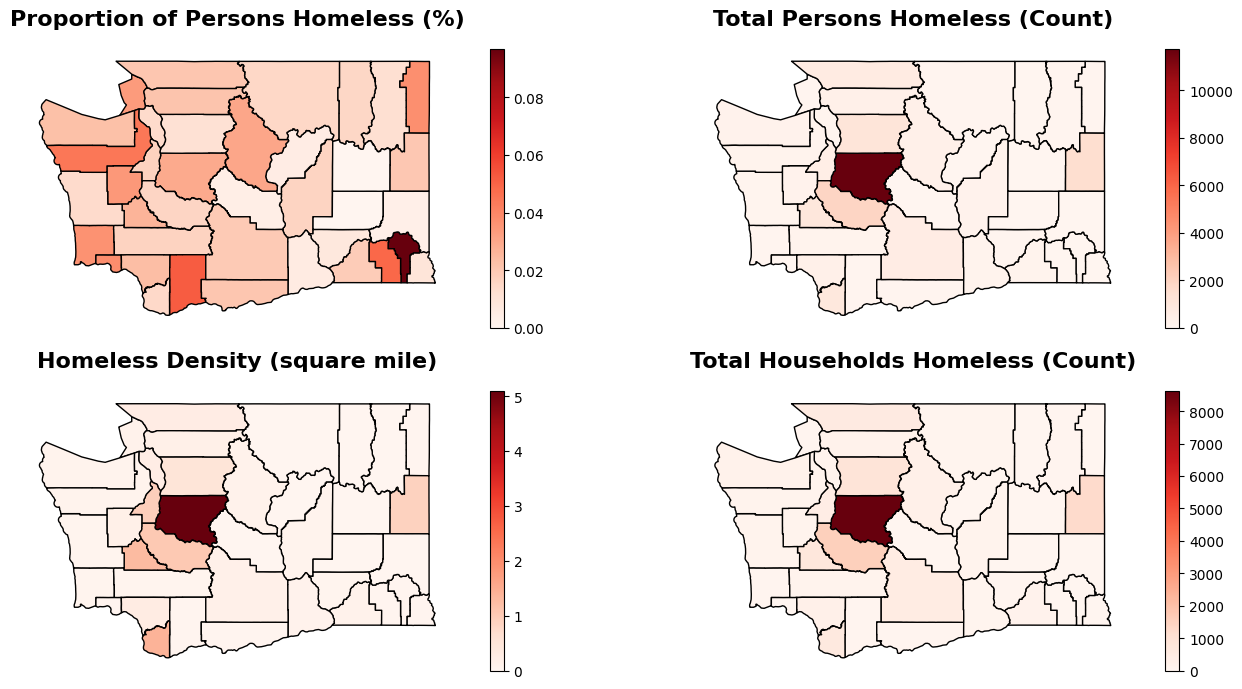

In [52]:
fig, axs = plt.subplots(2, 2, figsize=(14, 7))

titles = [
    "Proportion of Persons Homeless (%)",
    "Total Persons Homeless (Count)",
    "Homeless Density (square mile)" ,
    "Total Households Homeless (Count)"
]

data_columns = ['Proportion of Persons Homeless', 'Total Persons', 'Homeless Density', 'Total Households']  # Adjust these column names as per your DataFrame

for ax, title, column in zip(axs.flatten(), titles, data_columns):
    merged_homeless2020_data.plot(column=column, cmap='Reds', edgecolor='black', ax=ax, legend=True)
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_axis_off()

plt.tight_layout()
plt.show()

# Homeless Interactive Bar Chart Displaying Values Of Different Shelter Categories

This section of code uses the dataset homeless_shelter_data and melts it into one category of measure with values added up, then we visualized it using plotly library showing a bar graph of values comparsion between different factors.

In [53]:
homeless_shelter2020.head()

,Type,Category,Emergency_Shelter,Transitional_Housing,Safe_Haven,Total_Sheltered,Unsheltered,TOTAL
0,Households_one adult_one child,Households,781.0,767,-,1548.0,570.0,2118.0
1,Households_one adult_one child,Persons,2505.0,2336,-,4841.0,1891.0,6732.0
2,Households_ only_children,Households,68.0,26,-,94.0,224.0,318.0
3,Households_ only_children,Persons,95.0,47,-,142.0,308.0,450.0
4,Households_without_children,Households,5813.0,1048,81,6942.0,7888.0,14830.0


In [54]:
# Removing underscores and leading/trailing spaces from column names
homeless_shelter2020.columns = homeless_shelter2020.columns.str.replace('_', ' ').str.strip()
homeless_shelter2020['Type'] = homeless_shelter2020['Type'].str.replace('_', ' ').str.strip()
homeless_shelter2022.columns = homeless_shelter2022.columns.str.replace('_', ' ').str.strip()
homeless_shelter2022['Type'] = homeless_shelter2022['Type'].str.replace('_', ' ').str.strip()

In [55]:
def convert_to_numeric(value):
    """
    Converts a given value to a numeric type. If the value is a hyphen ('-')
    or contains a less-than sign ('<'), it is interpreted as '0'.

    Parameters:
    - value: The value to convert, which can be a number, a string representing
             a number, a hyphen ('-'), or a string with a less-than sign ('<').

    Returns:
    - The numeric representation of the input value if it can be converted
    """
    if value == '-':
        return 0
    elif '<' in str(value):
        return 0
    else:
        return pd.to_numeric(value)

##### 2020 #####
for column in ['Emergency Shelter', 'Transitional Housing', 'Safe Haven']:
    homeless_shelter2020[column] = homeless_shelter2020[column].apply(convert_to_numeric)
homeless_shelter2020['Safe Haven'] = pd.to_numeric(homeless_shelter2020['Safe Haven'].replace('-', 0))


homeless_shelter2020['Group'] = homeless_shelter2020['Type'].apply(lambda x: 'With Children' if 'child' in x else 'Without Children')

grouped_data = homeless_shelter2020.groupby(['Group', 'Category']).sum()


households_data = grouped_data.loc[(slice(None), 'Households'), :]
persons_data = grouped_data.loc[(slice(None), 'Persons'), :]

<ipython-input-55-660b9c0d8dd3>:28: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [56]:
##### 2022 #####
for column in ['Emergency Shelter', 'Transitional Housing', 'Safe Haven']:
    homeless_shelter2022[column] = homeless_shelter2022[column].apply(convert_to_numeric)
homeless_shelter2022['Safe Haven'] = pd.to_numeric(homeless_shelter2022['Safe Haven'].replace('-', 0))
homeless_shelter2022['Group'] = homeless_shelter2022['Type'].apply(lambda x: 'With Children' if 'child' in x else 'Without Children')
grouped_data2 = homeless_shelter2022.groupby(['Group', 'Category']).sum()

households_data2 = grouped_data2.loc[(slice(None), 'Households'), :]
persons_data2 = grouped_data2.loc[(slice(None), 'Persons'), :]

<ipython-input-56-1ef8bc6d2bc9>:6: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [57]:
print(homeless_shelter2022.columns)

Index(['Type', 'Category', 'Emergency Shelter', 'Transitional Housing',
       'Safe Haven', 'Total Sheltered', 'Unsheltered', 'Total', 'Group'],
      dtype='object')


### Shelter Statistics by Category Plot

In [58]:
##### 2020 Plot #####

melted_shelter_data = pd.melt(homeless_shelter2020, id_vars=['Group', 'Category'],
                              value_vars=['Emergency Shelter', 'Transitional Housing',
                              'Safe Haven', 'Unsheltered'], var_name='Shelter Type',
                                value_name='Count')

# Grouped data for plotting
grouped_data = melted_shelter_data.groupby(['Shelter Type', 'Category'])['Count'].sum().unstack().reset_index()

fig = go.Figure()

for category in grouped_data.columns[1:]:
    fig.add_trace(go.Bar(x=grouped_data['Shelter Type'], y=grouped_data[category], name=category))

fig.update_layout(
    title='Shelter Statistics by Category(2020)',
    xaxis_title='Shelter Type',
    yaxis_title='Count',
    barmode='group',
    width=1000,
    height=600
)

fig.show()

##### 2022 Plot #####
# Color bar is different colors, we couldn't figure out how to make it be consistent.

melted_shelter_data2 = pd.melt(homeless_shelter2022, id_vars=['Group', 'Category'],
                              value_vars=['Emergency Shelter', 'Transitional Housing',
                              'Safe Haven', 'Unsheltered'], var_name='Shelter Type',
                                value_name='Count')

# Replacing the string representation of the field to a plottable one
melted_shelter_data2['Count'] = melted_shelter_data2['Count'].replace('< 11', 11)
melted_shelter_data2['Count'] = pd.to_numeric(melted_shelter_data2['Count'])

grouped_data2 = melted_shelter_data2.groupby(['Shelter Type', 'Category'])['Count'].sum().unstack().reset_index()

fig = go.Figure()

for category in grouped_data2.columns[1:]:
    fig.add_trace(go.Bar(x=grouped_data2['Shelter Type'], y=grouped_data2[category], name=category))

fig.update_layout(
    title='Shelter Statistics by Category(2022)',
    xaxis_title='Shelter Type',
    yaxis_title='Count',
    barmode='group',
    width=1000,
    height=600
)

fig.show()

In [59]:
melted_shelter_data2

,Group,Category,Shelter Type,Count
0,With Children,Households,Emergency Shelter,958.0
1,With Children,Persons,Emergency Shelter,3120.0
2,With Children,Households,Emergency Shelter,71.0
3,With Children,Persons,Emergency Shelter,71.0
4,With Children,Households,Emergency Shelter,6341.0
...,...,...,...,...
83,Without Children,Unaccompanied Youth households,Unsheltered,2793.0
84,Without Children,Parenting Youth Households,Unsheltered,11.0
85,Without Children,Total number of persons,Unsheltered,1056.0
86,Without Children,Persons in parenting youth household,Unsheltered,11.0


### 2020 HOMELESS PEOPLE FOR EACH COUNTY

Plan: create a graph that visually displays the comparison between households w/out minors, households with minors, and the households with ONLY minors

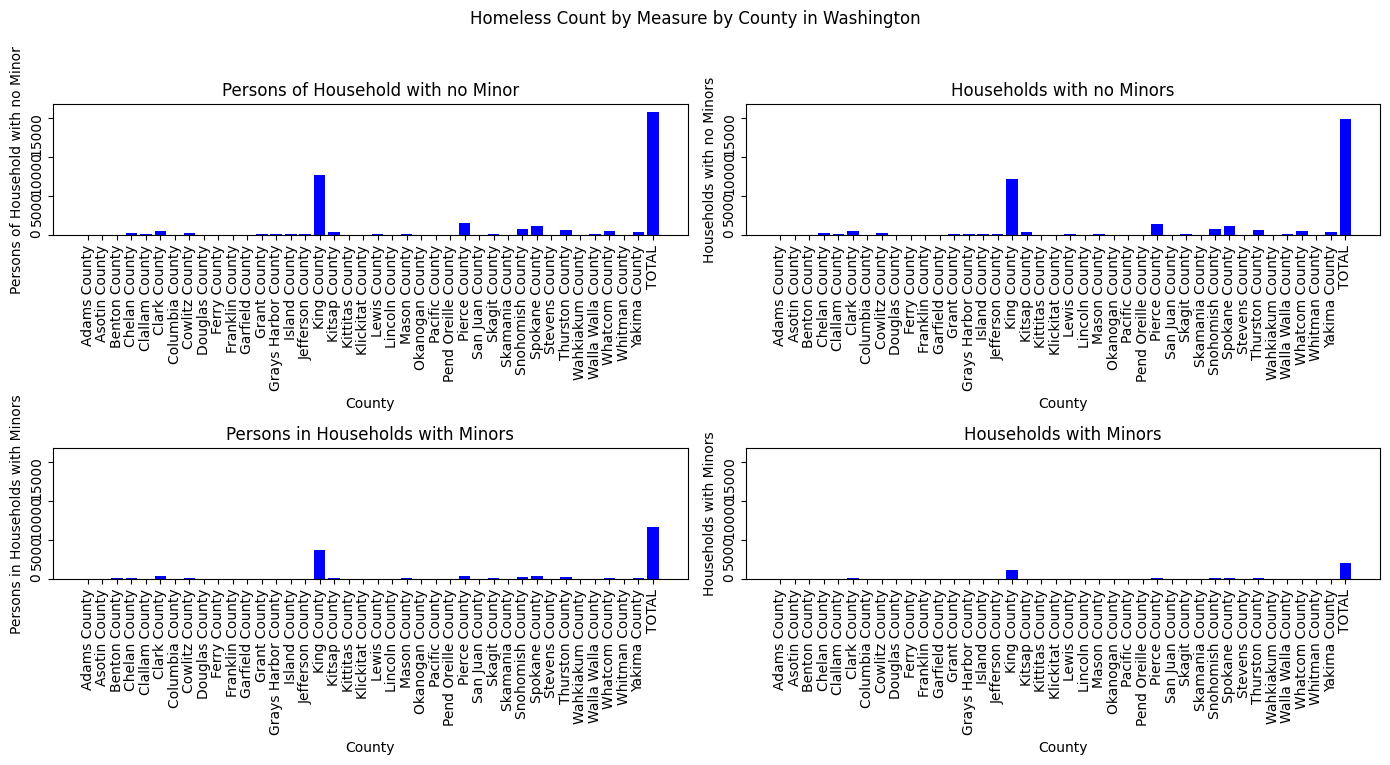

In [60]:
# Define the measures you want to plot, excluding total columns
measures = [
    'Persons of Household with no Minor',
    'Households with no Minors',
    'Persons in Households with Minors',
    'Households with Minors'
]

max_value = homeless2020[measures].max().max()
fig, axs = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle('Homeless Count by Measure by County in Washington')
axs = axs.flatten()

for i, measure in enumerate(measures):
    axs[i].bar(homeless2020['County'], homeless2020[measure], color='blue')
    axs[i].set_title(measure)
    axs[i].set_xlabel('County')
    axs[i].set_ylabel(measure)
    axs[i].tick_params(labelrotation=90)
    axs[i].set_ylim(0, max_value + 1000)  # to evenly space out the y axis labels and also set a consistent scale across all four subplots

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the overall title
plt.show()



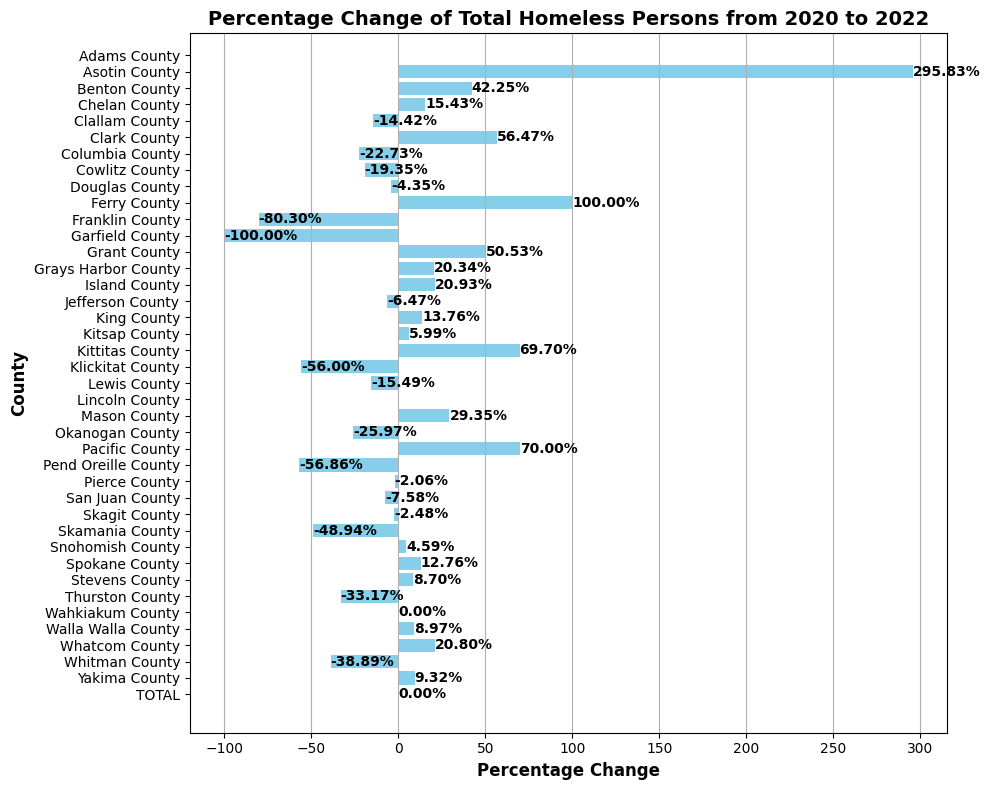

In [61]:
columns_graph = ['Persons of Household with no Minor',
           'Households with no Minors', 'Persons in Households with Minors',
           'Households with Minors', 'Persons in Households with only Minors',
           'Households with only Minors', 'Total Persons', 'Total Households']
# Calculate the percentage change between 2020 and 2022 datasets for each category
percentage_changes = {}
for column in columns_graph:
    percentage_changes[column] = ((homeless2022[column] - homeless2020[column]) / homeless2020[column]) * 100

# Create a horizontal bar graph
plt.figure(figsize=(10, 8))
plt.barh(homeless2022['County'], percentage_changes['Total Persons'], color='skyblue', label='Total Persons')
plt.xlabel('Percentage Change', fontweight='bold', fontsize=12, color='black')  # Brighter font
plt.ylabel('County', fontweight='bold', fontsize=12, color='black')  # Brighter font
plt.title('Percentage Change of Total Homeless Persons from 2020 to 2022', fontweight='bold', fontsize=14, color='black')  # Brighter font
plt.gca().invert_yaxis()  # Invert y-axis to match the image
plt.grid(axis='x')

# Add labels to the bars
for county, change in zip(homeless2022['County'], percentage_changes['Total Persons']):
    plt.text(change, county, f'{change:.2f}%', va='center', ha='left', fontsize=10, fontweight='bold', color='black')

plt.tight_layout()
plt.show()

In [62]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono
  fonts-texgyre fonts-urw-base35 libapache-pom-java libcommons-logging-java
  libcommons-parent-java libfontbox-java libfontenc1 libgs9 libgs9-common
  libidn12 libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1
  libruby3.0 libsynctex2 libteckit0 libtexlua53 libtexluajit2 libwoff1
  libzzip-0-13 lmodern poppler-data preview-latex-style rake ruby
  ruby-net-telnet ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0
  rubygems-integration t1utils teckit tex-common tex-gyre texlive-base
  texlive-binaries texlive-latex-base texlive-latex-extra
  texlive-latex-recommended texlive-pictures tipa xfonts-encodings
  xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf libavalon-framework-java
  libcommons-logging-java-doc libexcalibu

In [63]:
!jupyter nbconvert --to pdf /content/drive/MyDrive/CSE163 Project/CSE163.ipynb

[NbConvertApp] WARNING | pattern '/content/drive/MyDrive/CSE163' matched no files
[NbConvertApp] WARNING | pattern 'Project/CSE163.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions 